In [1]:
# =========================
# Cell 1: Imports + paths + reproducibility (required)
# =========================

import os, re, csv, json, random
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

PROJECT_ROOT = "."
DATA_DIR = os.path.join(PROJECT_ROOT, "Amazon_products")

TRAIN_CORPUS_PATH = os.path.join(DATA_DIR, "train", "train_corpus.txt")
TEST_CORPUS_PATH  = os.path.join(DATA_DIR, "test",  "test_corpus.txt")

CLASSES_PATH = os.path.join(DATA_DIR, "classes.txt")
HIER_PATH    = os.path.join(DATA_DIR, "class_hierarchy.txt")
KEYWORD_PATH = os.path.join(DATA_DIR, "class_related_keywords.txt")

ART_DIR = os.path.join(PROJECT_ROOT, "artifacts_main")
os.makedirs(ART_DIR, exist_ok=True)

NUM_CLASSES = 531
MIN_LABELS = 2
MAX_LABELS = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [2]:
# =========================
# Cell 2: Clean + Load Corpus
# =========================

TAG_RE = re.compile(r"<[^>]+>")

def clean_text(s: str) -> str:
    s = s or ""
    s = TAG_RE.sub(" ", s)
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

def load_corpus(path: str):
    pid2text = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip("\n").split("\t", 1)
            if len(parts) == 2:
                pid, text = parts
                pid2text[pid] = clean_text(text)
    return pid2text

pid2text_train = load_corpus(TRAIN_CORPUS_PATH)
pid2text_test  = load_corpus(TEST_CORPUS_PATH)
id_list_test   = list(pid2text_test.keys())

print("train:", len(pid2text_train), "test:", len(pid2text_test))


train: 29487 test: 19658


In [3]:
# =========================
# Cell 3: Load classes (robust) + hierarchy + adjacency matrix A_hat
# =========================

def load_classes(path):
    """
    Supports:
      - 'id<TAB>class name with spaces'
      - OR 'id<space>class name with spaces'
      - OR name-only per line
    """
    name2id, id2name = {}, {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            m = re.match(r"^(\d+)\s+(.+)$", line)
            if m:
                cid = int(m.group(1))
                cname = m.group(2).strip()
            else:
                parts = line.split("\t")
                if len(parts) == 2 and parts[0].isdigit():
                    cid = int(parts[0])
                    cname = parts[1].strip()
                else:
                    cid = len(id2name)
                    cname = line

            name2id[cname] = cid
            id2name[cid] = cname

    return name2id, id2name

name2id, id2name = load_classes(CLASSES_PATH)
assert len(id2name) == NUM_CLASSES, f"Expected {NUM_CLASSES}, got {len(id2name)}"
print("num classes loaded:", len(id2name))

def load_hierarchy(path):
    parents = defaultdict(set)  # child -> parents
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            p_str, c_str = line.split("\t")
            p, c = int(p_str), int(c_str)
            parents[c].add(p)
    return parents

parents = load_hierarchy(HIER_PATH)

def get_ancestors(cid: int) -> list:
    # nearest-first expansion (BFS-ish)
    seen = set()
    q = [cid]
    out = []
    while q:
        x = q.pop(0)
        for p in sorted(list(parents.get(x, []))):
            if p not in seen:
                seen.add(p)
                out.append(p)
                q.append(p)
    return out

def build_label_adj(num_classes, parents_dict, add_self_loop=True, undirected=True):
    A = np.zeros((num_classes, num_classes), dtype=np.float32)
    for child, ps in parents_dict.items():
        for p in ps:
            A[p, child] = 1.0
            if undirected:
                A[child, p] = 1.0
    if add_self_loop:
        np.fill_diagonal(A, 1.0)

    deg = A.sum(axis=1)
    deg_inv_sqrt = np.power(deg, -0.5, where=deg > 0)
    deg_inv_sqrt[deg == 0] = 0.0
    D_inv_sqrt = np.diag(deg_inv_sqrt)
    A_hat = D_inv_sqrt @ A @ D_inv_sqrt
    return torch.tensor(A_hat, dtype=torch.float32)

def expand_with_ancestors(core_labels, parents_dict):
    expanded = set(core_labels)
    stack = list(core_labels)
    while stack:
        c = stack.pop()
        for p in parents_dict.get(c, []):
            if p not in expanded:
                expanded.add(p)
                stack.append(p)
    return sorted(expanded)

A_hat = build_label_adj(NUM_CLASSES, parents).to(device)
print("A_hat:", A_hat.shape)


num classes loaded: 531
A_hat: torch.Size([531, 531])


In [4]:
# =========================
# Cell 4: Load class-related keywords (COLON format)
# =========================

def load_class_keywords(path, id2name):
    """
    Format expected:
    class_name:kw1,kw2,kw3,...
    """
    name2id = {v: k for k, v in id2name.items()}
    cid2kws = defaultdict(list)

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or ":" not in line:
                continue

            cname, rest = line.split(":", 1)
            cname = cname.strip()

            if cname not in name2id:
                # IMPORTANT: this prevents silent bugs
                continue

            cid = name2id[cname]
            kws = [clean_text(k) for k in rest.split(",")]
            kws = [k for k in kws if k]

            cid2kws[cid].extend(kws)

    # de-duplicate keywords per class
    for cid in cid2kws:
        cid2kws[cid] = list(dict.fromkeys(cid2kws[cid]))

    return cid2kws

cid2kws = load_class_keywords(KEYWORD_PATH, id2name)

print("Loaded keyword classes:", len(cid2kws))
print("Example:", id2name[0], cid2kws.get(0, [])[:10])


Loaded keywords for classes: 531


In [5]:
# =========================
# Cell 5: Silver label generation (keyword matching + hierarchy expansion), capped 2–3 labels
# =========================

_kw_regex_cache = {}

def kw_match(text: str, kw: str) -> bool:
    if " " in kw:
        return kw in text
    if kw not in _kw_regex_cache:
        _kw_regex_cache[kw] = re.compile(rf"\b{re.escape(kw)}\b")
    return _kw_regex_cache[kw].search(text) is not None

def score_doc(text: str) -> dict:
    scores = defaultdict(float)
    for cid, kws in cid2kws.items():
        for j, kw in enumerate(kws):
            if kw and kw_match(text, kw):
                scores[cid] += 1.0 / (1.0 + np.log1p(j + 1))  # simple heuristic
    return scores

def predict_labels_with_hierarchy(text: str, k_min=2, k_max=3) -> list:
    scores = score_doc(text)
    if not scores:
        return []

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)

    chosen, chosen_set = [], set()

    for cid, _ in ranked:
        if cid not in chosen_set:
            chosen.append(cid); chosen_set.add(cid)

        # add ancestors until reaching k_max
        for anc in get_ancestors(cid):
            if len(chosen) >= k_max:
                break
            if anc not in chosen_set:
                chosen.append(anc); chosen_set.add(anc)

        if len(chosen) >= k_max:
            break

    # ensure at least k_min labels
    if len(chosen) < k_min:
        for cid, _ in ranked:
            if cid not in chosen_set:
                chosen.append(cid); chosen_set.add(cid)
            if len(chosen) >= k_min:
                break

    return sorted(chosen[:k_max])

TRAIN_SILVER_PATH = os.path.join(ART_DIR, "train_silver_labels.csv")

train_rows = []
for pid, text in tqdm(pid2text_train.items(), desc="Generating train silver labels"):
    labs = predict_labels_with_hierarchy(text, k_min=MIN_LABELS, k_max=MAX_LABELS)
    if not labs:
        continue
    train_rows.append({"pid": pid, "text": text, "labels": ",".join(map(str, labs))})

train_silver_df = pd.DataFrame(train_rows)
train_silver_df.to_csv(TRAIN_SILVER_PATH, index=False)

print("Saved:", TRAIN_SILVER_PATH, "rows:", len(train_silver_df))
train_silver_df.head()


Generating train silver labels: 100%|██████████| 29487/29487 [17:52<00:00, 27.49it/s]


Saved: ./artifacts/train_silver_labels.csv rows: 19500


,pid,text,labels
0,0,omron hem 790it automatic blood pressure monit...,"40,145,502"
1,1,natural factors whey factors chocolate works w...,"0,271,455"
2,2,"clif bar builder 's bar , 2 . 4 ounce bars i l...","0,8,366"
3,4,clif bar energy bars these were cheaper than w...,"0,271,449"
4,9,lumiscope stirrup stockings pair these are ver...,"169,199,382"


In [10]:
# =========================
# Cell 6: Frozen BERT embeddings for documents (no fine-tuning)
# =========================

from transformers import AutoTokenizer, AutoModel

MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert = AutoModel.from_pretrained(MODEL_NAME).to(device)
bert.eval()

@torch.no_grad()
def embed_texts(texts, batch_size=32, max_length=256):
    vecs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding docs"):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)
        out = bert(**enc).last_hidden_state
        mask = enc["attention_mask"].unsqueeze(-1)
        pooled = (out * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
        vecs.append(pooled.detach().cpu().numpy())
    return np.vstack(vecs)

train_texts = train_silver_df["text"].astype(str).tolist()
test_texts  = [pid2text_test[i] for i in id_list_test]

X_train = embed_texts(train_texts, batch_size=32, max_length=256)
X_test  = embed_texts(test_texts,  batch_size=32, max_length=256)

np.save(os.path.join(ART_DIR, "train_bert.npy"), X_train)
np.save(os.path.join(ART_DIR, "test_bert.npy"),  X_test)
json.dump(train_silver_df["pid"].astype(str).tolist(), open(os.path.join(ART_DIR, "train_ids.json"), "w"))
json.dump(id_list_test, open(os.path.join(ART_DIR, "test_ids.json"), "w"))

print("Saved embeddings:", X_train.shape, X_test.shape)


Embedding docs: 100%|██████████| 615/615 [02:11<00:00,  4.68it/s]

Saved embeddings: (19500, 768) (19658, 768)


In [7]:
# =========================
# Cell 7: Build E_label (label embeddings) from class name + keywords (frozen BERT)
# =========================

def build_label_texts(id2name, cid2kws, topk=8):
    texts = []
    for cid in range(NUM_CLASSES):
        name = id2name[cid]
        kws = cid2kws.get(cid, [])[:topk]
        texts.append(clean_text(name) + " ; keywords: " + ", ".join(kws))
    return texts

@torch.no_grad()
def embed_label_texts(texts, batch_size=64, max_length=64):
    embs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding labels"):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)
        out = bert(**enc).last_hidden_state
        mask = enc["attention_mask"].unsqueeze(-1)
        pooled = (out * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
        embs.append(pooled.detach().cpu())
    return torch.cat(embs, dim=0)

label_texts = build_label_texts(id2name, cid2kws, topk=8)
E_label = embed_label_texts(label_texts)  # (C, 768) on CPU
print("E_label:", E_label.shape)


Embedding labels: 100%|██████████| 9/9 [00:00<00:00, 11.08it/s]

E_label: torch.Size([531, 768])


In [11]:
# =========================
# Cell 8: Dataset + train/val split
# =========================

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

def labels_str_to_target(labels_str, num_classes=NUM_CLASSES):
    y = torch.zeros(num_classes, dtype=torch.float32)
    for t in str(labels_str).split(","):
        t = t.strip()
        if t:
            y[int(t)] = 1.0
    return y

class SilverEmbDataset(Dataset):
    def __init__(self, X, core_label_strs, all_label_strs):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.core_label_strs = list(core_label_strs)
        self.all_label_strs  = list(all_label_strs)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        y_core = labels_str_to_target(self.core_label_strs[i])
        y_all  = labels_str_to_target(self.all_label_strs[i])
        return {"X": self.X[i], "y_core": y_core, "y": y_all}  # keep key "y" for eval code


X_train = np.load(os.path.join(ART_DIR, "train_bert.npy"))
X_test  = np.load(os.path.join(ART_DIR, "test_bert.npy"))
label_strs = train_silver_df["labels"].astype(str).tolist()
X_tr, X_va, s_tr, s_va = train_test_split(X_train, label_strs, test_size=0.1, random_state=42)

train_loader = DataLoader(SilverEmbDataset(X_tr, s_tr), ...)
val_loader   = DataLoader(SilverEmbDataset(X_va, s_va), ...)

print("train batches:", len(train_loader), "val batches:", len(val_loader))


train batches: 138 val batches: 8


In [12]:
# =========================
# Cell 9: LabelGCN model (GNN) with E_label initialization
# =========================

class LabelGCN(nn.Module):
    def __init__(self, emb_dim, num_layers=2, dropout=0.2):
        super().__init__()
        self.weights = nn.ParameterList([nn.Parameter(torch.empty(emb_dim, emb_dim)) for _ in range(num_layers)])
        for W in self.weights:
            nn.init.xavier_uniform_(W)
        self.num_layers = num_layers
        self.dropout = dropout

    def forward(self, H, A_hat):
        for i, W in enumerate(self.weights):
            H = A_hat @ H
            H = H @ W
            if i < self.num_layers - 1:
                H = F.relu(H)
                H = F.dropout(H, p=self.dropout, training=self.training)
        return H

class GCNEnhancedClassifier(nn.Module):
    def __init__(self, input_dim, num_labels, emb_dim, num_gcn_layers, dropout, A_hat, E_label_init):
        super().__init__()
        self.proj = nn.Linear(input_dim, emb_dim)
        self.gcn = LabelGCN(emb_dim, num_layers=num_gcn_layers, dropout=dropout)
        self.dropout = dropout
        self.register_buffer("A_hat", A_hat)

        # ---- FIX: initialize label_emb on CPU safely ----
        if E_label_init.shape[1] != emb_dim:
            label_init_proj = nn.Linear(E_label_init.shape[1], emb_dim, bias=False)  # CPU layer
            with torch.no_grad():
                init = label_init_proj(E_label_init.cpu()).clone()  # CPU -> CPU
        else:
            init = E_label_init.cpu().clone()

        self.label_emb = nn.Parameter(init)  # stays as parameter; will move with .to(device)

    def forward(self, x):
        x_proj = F.relu(self.proj(x))
        x_proj = F.dropout(x_proj, p=self.dropout, training=self.training)

        # move label_emb to same device as x_proj
        label_emb = self.gcn(self.label_emb.to(x_proj.device), self.A_hat)

        logits = x_proj @ label_emb.t()
        return logits


model = GCNEnhancedClassifier(
    input_dim=X_train.shape[1],
    num_labels=NUM_CLASSES,
    emb_dim=256,
    num_gcn_layers=2,
    dropout=0.2,
    A_hat=A_hat,
    E_label_init=E_label,
).to(device)

print(model)


GCNEnhancedClassifier(
  (proj): Linear(in_features=768, out_features=256, bias=True)
  (gcn): LabelGCN(
    (weights): ParameterList(
        (0): Parameter containing: [torch.float32 of size 256x256 (cuda:0)]
        (1): Parameter containing: [torch.float32 of size 256x256 (cuda:0)]
    )
  )
)


In [23]:
# =========================
# Cell 10: Training (proper) + evaluation with 2–3 constraint
# =========================

import copy
from torch.cuda.amp import autocast, GradScaler

def compute_pos_weight(label_strs, num_classes):
    counts = np.zeros(num_classes, dtype=np.float64)
    n = len(label_strs)
    for s in label_strs:
        for t in str(s).split(","):
            t = t.strip()
            if t:
                counts[int(t)] += 1
    pos = np.clip(counts, 1.0, None)
    neg = n - counts
    return torch.tensor(neg / pos, dtype=torch.float32)

pos_weight = compute_pos_weight(s_tr, NUM_CLASSES).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def probs_to_k_labels(p, thr3=0.35, min_l=2, max_l=3):
    idx = np.argsort(p)[::-1]
    top2 = [int(idx[0]), int(idx[1])]
    third = int(idx[2])
    chosen = top2
    if p[third] >= thr3 and max_l >= 3:
        chosen = top2 + [third]
    if len(chosen) < min_l:
        chosen = [int(x) for x in idx[:min_l]]
    return sorted(chosen[:max_l])

def sample_f1_score(y_true, y_pred):
    eps = 1e-9
    tp = (y_true * y_pred).sum(axis=1)
    fp = ((1 - y_true) * y_pred).sum(axis=1)
    fn = (y_true * (1 - y_pred)).sum(axis=1)
    f1 = (2 * tp) / (2 * tp + fp + fn + eps)
    return float(np.mean(f1))

@torch.no_grad()
def evaluate_sample_f1(model, loader, thr3=0.35, min_l=2, max_l=3):
    model.eval()
    all_true, all_pred = [], []
    for batch in loader:
        Xb = batch["X"].to(device)
        yb = batch["y"].cpu().numpy()
        logits = model(Xb)
        probs = torch.sigmoid(logits).cpu().numpy()

        yhat = np.zeros_like(probs, dtype=np.float32)
        for i in range(probs.shape[0]):
            labs = probs_to_k_labels(probs[i], thr3=thr3, min_l=min_l, max_l=max_l)
            yhat[i, labs] = 1.0

        all_true.append(yb)
        all_pred.append(yhat)

    return sample_f1_score(np.vstack(all_true), np.vstack(all_pred))

def graph_smoothness_loss(probs, A_hat):
    Ap = probs @ A_hat.t()
    return ((probs - Ap) ** 2).mean()

def train_model(model, train_loader, val_loader,
                epochs=100, lr=2e-3, wd=1e-4, lmbda=0.25, patience=10, thr3=0.35):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scaler = GradScaler(enabled=torch.cuda.is_available())

    best_val = -1.0
    best_state = None
    pat = 0

    for ep in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        for batch in train_loader:
            Xb = batch["X"].to(device)
            yb = batch["y"].to(device)

            optimizer.zero_grad(set_to_none=True)

            with autocast(enabled=torch.cuda.is_available()):
                logits = model(Xb)
                loss_sup = criterion(logits, yb)
                probs = torch.sigmoid(logits)
                loss_g = graph_smoothness_loss(probs, A_hat)
                loss = loss_sup + lmbda * loss_g

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += float(loss.detach().cpu())

        val_f1 = evaluate_sample_f1(model, val_loader, thr3=thr3, min_l=MIN_LABELS, max_l=MAX_LABELS)
        print(f"[Epoch {ep:02d}] loss={total_loss/len(train_loader):.4f} | val_sampleF1={val_f1:.4f}")

        if val_f1 > best_val:
            best_val = val_f1
            best_state = copy.deepcopy(model.state_dict())
            pat = 0
            print("  ✅ improved")
        else:
            pat += 1
            print(f"  ⏳ no improvement ({pat}/{patience})")
            if pat >= patience:
                print("[Early Stopping]")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
        print("Loaded best model. best val sample-F1:", best_val)

    return model, best_val

model, best_val = train_model(model, train_loader, val_loader,
                              epochs=50, lr=2e-3, wd=1e-4, lmbda=0.25, patience=5, thr3=0.35)


/tmp/ipykernel_6989/4180509799.py:69: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipykernel_6989/4180509799.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


[Epoch 01] loss=0.4559 | val_sampleF1=0.1643
  ✅ improved
[Epoch 02] loss=0.4438 | val_sampleF1=0.1297
  ⏳ no improvement (1/5)
[Epoch 03] loss=0.4358 | val_sampleF1=0.1088
  ⏳ no improvement (2/5)
[Epoch 04] loss=0.4309 | val_sampleF1=0.1095
  ⏳ no improvement (3/5)
[Epoch 05] loss=0.4183 | val_sampleF1=0.1906
  ✅ improved
[Epoch 06] loss=0.4191 | val_sampleF1=0.1365
  ⏳ no improvement (1/5)
[Epoch 07] loss=0.4170 | val_sampleF1=0.1448
  ⏳ no improvement (2/5)
[Epoch 08] loss=0.4143 | val_sampleF1=0.1510
  ⏳ no improvement (3/5)
[Epoch 09] loss=0.4083 | val_sampleF1=0.1423
  ⏳ no improvement (4/5)
[Epoch 10] loss=0.4310 | val_sampleF1=0.1935
  ✅ improved
[Epoch 11] loss=0.4579 | val_sampleF1=0.1668
  ⏳ no improvement (1/5)
[Epoch 12] loss=0.4404 | val_sampleF1=0.1241
  ⏳ no improvement (2/5)
[Epoch 13] loss=0.4322 | val_sampleF1=0.1600
  ⏳ no improvement (3/5)
[Epoch 14] loss=0.4268 | val_sampleF1=0.1055
  ⏳ no improvement (4/5)
[Epoch 15] loss=0.4112 | val_sampleF1=0.1708
  ⏳ no impr

In [24]:
# =========================
# Cell 11: Predict test + write Kaggle submission (2–3 labels guaranteed)
# =========================

id_list_test = json.load(open(os.path.join(ART_DIR, "test_ids.json")))

model.eval()
with torch.no_grad():
    probs_test = torch.sigmoid(model(torch.tensor(X_test, dtype=torch.float32).to(device))).cpu().numpy()

THR3 = 0.35
pred_labels = [probs_to_k_labels(p, thr3=THR3, min_l=MIN_LABELS, max_l=MAX_LABELS) for p in probs_test]

SUBMISSION_PATH = os.path.join(PROJECT_ROOT, "submission_1.csv")
with open(SUBMISSION_PATH, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["id", "label"])  # keep consistent with your earlier submission format
    for id_, labs in zip(id_list_test, pred_labels):
        w.writerow([id_, ",".join(map(str, labs))])

print("Saved:", SUBMISSION_PATH, "rows:", len(pred_labels))


Saved: ./submission_1.csv rows: 19658


HVR = 0.6369  (violations=28394 / child_preds=44583)


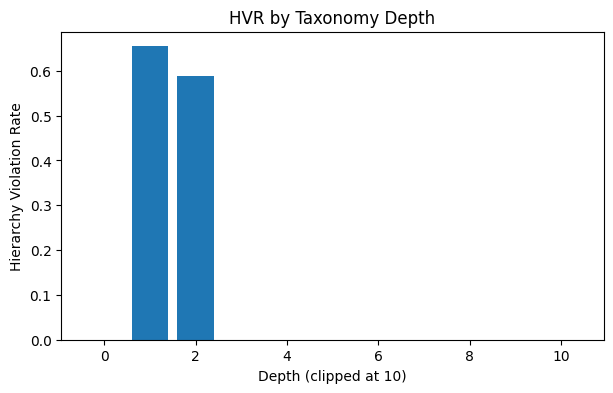

In [25]:
# =========================
# Cell 12: Hierarchy Violation Rate (HVR)
# =========================

import numpy as np
import matplotlib.pyplot as plt

# 1) Compute depth of each label (for "HVR by depth" plot)
# If DAG has multiple parents, we take MIN depth from any root.
def compute_depths(num_classes, parents):
    depths = np.full(num_classes, -1, dtype=int)

    # roots: labels with no parents
    roots = [c for c in range(num_classes) if len(parents.get(c, set())) == 0]
    from collections import deque
    q = deque(roots)
    for r in roots:
        depths[r] = 0

    # build children adjacency for BFS
    children = {i: [] for i in range(num_classes)}
    for child, ps in parents.items():
        for p in ps:
            children[p].append(child)

    while q:
        u = q.popleft()
        for v in children[u]:
            nd = depths[u] + 1
            if depths[v] == -1 or nd < depths[v]:
                depths[v] = nd
                q.append(v)

    # fallback: if any disconnected nodes remain, set depth=0
    depths[depths == -1] = 0
    return depths

depths = compute_depths(NUM_CLASSES, parents)

# 2) HVR computation
# Violation: predicted child label but NONE of its parents are predicted.
def compute_hvr(pred_labels, parents):
    total_child_preds = 0
    violations = 0

    for labs in pred_labels:
        S = set(labs)
        for c in labs:
            ps = parents.get(c, set())
            if len(ps) == 0:
                continue  # root has no parent constraint
            total_child_preds += 1
            if len(S.intersection(ps)) == 0:
                violations += 1

    hvr = violations / max(total_child_preds, 1)
    return hvr, violations, total_child_preds

hvr, v_cnt, child_cnt = compute_hvr(pred_labels, parents)
print(f"HVR = {hvr:.4f}  (violations={v_cnt} / child_preds={child_cnt})")

# 3) HVR by depth (visual)
def hvr_by_depth(pred_labels, parents, depths, max_depth=10):
    # returns arrays depth -> (violations, total)
    viol = np.zeros(max_depth+1, dtype=int)
    tot  = np.zeros(max_depth+1, dtype=int)

    for labs in pred_labels:
        S = set(labs)
        for c in labs:
            ps = parents.get(c, set())
            if len(ps) == 0:
                continue
            d = int(min(depths[c], max_depth))
            tot[d] += 1
            if len(S.intersection(ps)) == 0:
                viol[d] += 1

    rate = viol / np.maximum(tot, 1)
    return rate, viol, tot

rate, viol, tot = hvr_by_depth(pred_labels, parents, depths, max_depth=10)

plt.figure(figsize=(7,4))
plt.bar(np.arange(len(rate)), rate)
plt.xlabel("Depth (clipped at 10)")
plt.ylabel("Hierarchy Violation Rate")
plt.title("HVR by Taxonomy Depth")
plt.show()


In [34]:
pip install openTSNE

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openTSNE: filename=opentsne-1.0.4-cp39-cp39-linux_x86_64.whl size=626828 sha256=5b20ad278f39de4faaed79e9968dc70fe121879433da306eb4abce0180104f0e
  Stored in directory: /home/sagemaker-user/.cache/pip/wheels/28/3c/c2/51ab1320a45b3491c26a66ec43c55ecb47690c2d153c68550f
Successfully built openTSNE
Note: you may need to restart the kernel to use updated packages.


In [36]:
# =========================
# Cell 13: t-SNE visualization (openTSNE, avoids sklearn BallTree issues)
# =========================

import numpy as np
import matplotlib.pyplot as plt

try:
    from openTSNE import TSNE
except ImportError:
    raise ImportError("openTSNE not installed. Run: pip install openTSNE")

model.eval()

n_docs = min(1500, X_test.shape[0])
idx = np.random.RandomState(SEED).choice(X_test.shape[0], size=n_docs, replace=False)
X_plot = torch.tensor(X_test[idx], dtype=torch.float32).to(device)

with torch.no_grad():
    doc_z = F.relu(model.proj(X_plot)).cpu().numpy()
    label_z = model.gcn(model.label_emb.to(device), model.A_hat).cpu().numpy()

with torch.no_grad():
    probs = torch.sigmoid(model(X_plot)).cpu().numpy()
top1 = probs.argmax(axis=1)

Z_all = np.vstack([doc_z, label_z]).astype(np.float32)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    initialization="pca",
    metric="cosine",
    random_state=SEED,
    n_jobs=4
)
Z_2d = tsne.fit(Z_all)

doc_2d = np.asarray(Z_2d[:n_docs])
lab_2d = np.asarray(Z_2d[n_docs:])

plt.figure(figsize=(8,6))
plt.scatter(doc_2d[:,0], doc_2d[:,1], s=6, alpha=0.4, c=top1)
plt.scatter(lab_2d[:,0], lab_2d[:,1], s=40, marker="x")
plt.title("t-SNE: Documents (colored by top-1 predicted label) + Labels (x)")
plt.xlabel("dim-1")
plt.ylabel("dim-2")
plt.show()


ImportError: openTSNE not installed. Run: pip install openTSNE

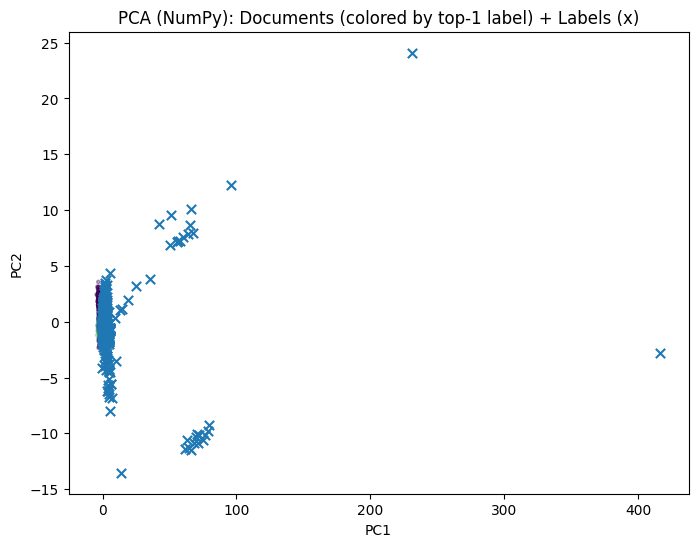

In [38]:
# =========================
# Cell 13: Visualization (Pure NumPy PCA) — no sklearn required
# Documents + Labels in same 2D space
# =========================

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

model.eval()

# --- sample docs to keep plot fast ---
n_docs = min(2000, X_test.shape[0])
rng = np.random.RandomState(SEED)
idx = rng.choice(X_test.shape[0], size=n_docs, replace=False)

X_plot = torch.tensor(X_test[idx], dtype=torch.float32).to(device)

with torch.no_grad():
    # document embeddings in label space (after projection)
    doc_z = F.relu(model.proj(X_plot)).cpu().numpy()              # (n_docs, 256)

    # label embeddings after LabelGCN
    label_z = model.gcn(model.label_emb.to(device), model.A_hat).cpu().numpy()  # (531, 256)

    # color docs by top-1 predicted label
    probs = torch.sigmoid(model(X_plot)).cpu().numpy()
    top1 = probs.argmax(axis=1)

Z = np.vstack([doc_z, label_z]).astype(np.float32)  # (n_docs+531, 256)

# --- Pure NumPy PCA via SVD ---
Zc = Z - Z.mean(axis=0, keepdims=True)
U, S, Vt = np.linalg.svd(Zc, full_matrices=False)
Z_2d = Zc @ Vt[:2].T

doc_2d = Z_2d[:n_docs]
lab_2d = Z_2d[n_docs:]

plt.figure(figsize=(8, 6))
plt.scatter(doc_2d[:, 0], doc_2d[:, 1], s=6, alpha=0.35, c=top1)
plt.scatter(lab_2d[:, 0], lab_2d[:, 1], s=45, marker="x")
plt.title("PCA (NumPy): Documents (colored by top-1 label) + Labels (x)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
